In [ ]:
#@title  <-- Run Me: (Hidden) Installing Spark
%%bash 

## Setup Spark on Colab
pip install -q pyspark
apt-get -qq install -y openjdk-8-jdk-headless
pip install -q elephas

## Setup port-forwarding

# Download ngrok
wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# Unload ngrok
unzip -q ngrok-stable-linux-amd64.zip

replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [ ]:
#@title  <-- Run Me: (Hidden) Environment Variable Setup
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import pyspark 
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# Set configuration scope to be local and use port 4050
config_scope = SparkConf().set("spark.ui.port", "4050")

# Create the connection to a Spark cluster
sc = pyspark.SparkContext(conf = config_scope)

# Create a session to programmatically build Spark RDD, DataFrame and DataSet
spark = SparkSession.builder.getOrCreate()

In [ ]:
#@title (Hidden) Diagnostic Check
import os
import sys
import pandas as pd
import numpy as np

print(f"python: {sys.version}")
print(f"pyspark: {sc.version}")
print(f"pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")

try:
  from google.colab import drive
  is_google_colab = True

  print("Notebook is on Google CoLab")
except:
  is_google_colab = False
  print("Notebook is being run locally or through another source.")


python: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
pyspark: 3.2.0
pandas: 1.3.5
NumPy: 1.21.6
Notebook is on Google CoLab


In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: ignored

In [ ]:
raw_train_data = spark.read.option("delimiter", "|").options(header = True, inferSchema = True).csv("/content/drive/MyDrive/train_data.csv")
raw_train_data.printSchema()
temp, temp1=raw_train_data.randomSplit([0.1, 0.9])
train, test=temp.randomSplit([0.95, 0.05])

root
 |-- label: integer (nullable = true)
 |-- uid: integer (nullable = true)
 |-- task_id: integer (nullable = true)
 |-- adv_id: integer (nullable = true)
 |-- creat_type_cd: integer (nullable = true)
 |-- adv_prim_id: integer (nullable = true)
 |-- dev_id: integer (nullable = true)
 |-- inter_type_cd: integer (nullable = true)
 |-- slot_id: integer (nullable = true)
 |-- spread_app_id: integer (nullable = true)
 |-- tags: integer (nullable = true)
 |-- app_first_class: integer (nullable = true)
 |-- app_second_class: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- city: integer (nullable = true)
 |-- city_rank: integer (nullable = true)
 |-- device_name: integer (nullable = true)
 |-- device_size: integer (nullable = true)
 |-- career: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- net_type: integer (nullable = true)
 |-- residence: integer (nullable = true)
 |-- his_app_size: integer (nullable = true)
 |-- his_on_shelf_time: integer (nulla

In [ ]:
from pyspark.ml.feature import VectorAssembler
# Apply the transformation and rename columns
id_df = train.select("uid", "task_id","adv_id")
train_df=train.drop("uid", "task_id","adv_id","communication_onlinerate")

In [ ]:
# Dynamically generate name of columns
vecAssembler = VectorAssembler(
    inputCols = train_df.columns[1:],
    outputCol = "features")

# Apply the transformation
vec_data = vecAssembler.transform(train_df)
train_data_new=vec_data.select("label","features")


In [ ]:
id_df_test = test.select("uid", "task_id","adv_id")
test_df=test.drop("uid", "task_id","adv_id","communication_onlinerate")
# Dynamically generate name of columns
vecAssembler = VectorAssembler(
    inputCols = test_df.columns[1:],
    outputCol = "features")

# Apply the transformation
vec_data = vecAssembler.transform(test_df)
test_data_new=vec_data.select("label","features")

In [ ]:
train1DF = train_data_new.where("label=1")
ONumber = train1DF.count()
train0DF = train_data_new.where("label=0")
ZNumber = train0DF.count()
ratio = ONumber/(ZNumber)
sampleNormalDF = train0DF.sample(False, ratio, 10)
underDF = train1DF.union(sampleNormalDF)

## Deep learning

In [ ]:
from pyspark.ml.linalg import Vectors
import numpy as np
import random
import tensorflow
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml import Pipeline

from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

from elephas.ml_model import ElephasEstimator

In [ ]:
dim=len(underDF.select("features").first()[0])
model=Sequential()
model.add(Dense(128,input_shape=(dim,),activity_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(128,activity_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')

In [ ]:
#optimizer_coef=Adam(lr=0.01)
#opt_coef=optimizers.serialize(optimizer_coef)
optimizer_coef = optimizers.Adam(lr=0.01)
opt_coef = optimizers.serialize(optimizer_coef)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
estimate=ElephasEstimator()
estimate.setFeaturesCol("features")
estimate.setLabelCol("label")
estimate.set_keras_model_config(model.to_json())
estimate.set_categorical_labels(True)
estimate.set_nb_classes(2)
estimate.set_num_workers(1)
estimate.set_epochs(25)
estimate.set_batch_size(64)
estimate.set_verbosity(1)
estimate.set_validation_split(0.1)
estimate.set_optimizer_config(opt_coef)
estimate.set_mode("synchronous")
estimate.set_loss("binary_crossentropy")
estimate.set_metrics(["acc"])

ElephasEstimator_4822113b019a

In [ ]:
dl_pipeline=Pipeline(stages=[estimate])
fit_dl=dl_pipeline.fit(underDF)

>>> Fit model
>>> Synchronous training complete.


In [ ]:
#pred_train=fit_dl.transform(underDF)
pred_test=fit_dl.transform(test_data_new)

In [ ]:
pnl = pred_test.select("label","prediction")
pnl.head(50)

[Row(label=0, prediction=[0.438194215297699, 0.5616056323051453]),
 Row(label=0, prediction=[0.5163557529449463, 0.4836386442184448]),
 Row(label=0, prediction=[0.40139707922935486, 0.5984794497489929]),
 Row(label=0, prediction=[0.3933424949645996, 0.6066682934761047]),
 Row(label=0, prediction=[0.4820730984210968, 0.5178900361061096]),
 Row(label=0, prediction=[0.4340554177761078, 0.5658337473869324]),
 Row(label=0, prediction=[0.41489601135253906, 0.5851355791091919]),
 Row(label=0, prediction=[0.5241385102272034, 0.4758770763874054]),
 Row(label=0, prediction=[0.4530496299266815, 0.5468299388885498]),
 Row(label=0, prediction=[0.5099837779998779, 0.48999398946762085]),
 Row(label=0, prediction=[0.37734025716781616, 0.622628390789032]),
 Row(label=0, prediction=[0.4359513223171234, 0.5640239119529724]),
 Row(label=0, prediction=[0.46863946318626404, 0.5313493013381958]),
 Row(label=0, prediction=[0.3562997281551361, 0.6437332034111023]),
 Row(label=0, prediction=[0.5213179588317871,

In [ ]:
pnl.tail(50)

[Row(label=1, prediction=[0.3184173107147217, 0.6816353797912598]),
 Row(label=1, prediction=[0.40757182240486145, 0.5923088192939758]),
 Row(label=1, prediction=[0.33075153827667236, 0.6694265604019165]),
 Row(label=1, prediction=[0.3710591197013855, 0.6289851069450378]),
 Row(label=1, prediction=[0.27900463342666626, 0.7210713624954224]),
 Row(label=1, prediction=[0.31854450702667236, 0.6816060543060303]),
 Row(label=1, prediction=[0.3194119334220886, 0.6806076765060425]),
 Row(label=1, prediction=[0.29181569814682007, 0.7083054780960083]),
 Row(label=1, prediction=[0.3233720064163208, 0.6768039464950562]),
 Row(label=1, prediction=[0.37393718957901, 0.6261382102966309]),
 Row(label=1, prediction=[0.4349546730518341, 0.5649554133415222]),
 Row(label=1, prediction=[0.3644590675830841, 0.6355600953102112]),
 Row(label=1, prediction=[0.33881425857543945, 0.6614755392074585]),
 Row(label=1, prediction=[0.3894408643245697, 0.6106200218200684]),
 Row(label=1, prediction=[0.3038020133972168

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics
pred_and_label_test=pnl.rdd.map(lambda row: (row['label'],row['prediction']))
metrics=MulticlassMetrics(pred_and_label_test)

TypeError: ignored

In [ ]:
pred_and_label_test.first()

(0, [0.48643019795417786, 0.5138109922409058])

In [ ]:
print("Accuracy: {}".format(round(metrics.accuracy(),4)))

In [ ]:
causaldf=train.tail(500)

In [ ]:
test.where("label=1").show()

+-----+-------+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+----------------+---+----+---------+-----------+-----------+------+------+--------+---------+------------+-----------------+---------+--------+---------+------------+----------------+-------------------+------------------------+----------------+------------------------+---------------------------+---------+----+
|label|    uid|task_id|adv_id|creat_type_cd|adv_prim_id|dev_id|inter_type_cd|slot_id|spread_app_id|tags|app_first_class|app_second_class|age|city|city_rank|device_name|device_size|career|gender|net_type|residence|his_app_size|his_on_shelf_time|app_score|emui_dev|list_time|device_price|up_life_duration|up_membership_grade|membership_life_duration|consume_purchase|communication_onlinerate|communication_avgonline_30d|indu_name|pt_d|
+-----+-------+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+------------

In [ ]:
test1DF = test.where("label=1")
ONumber = test1DF.count()
test0DF = test.where("label=0")
ZNumber = test0DF.count()
ratio = ONumber/(ZNumber)
sampleNormalDF = test0DF.sample(False, ratio, 10)
underDF = test1DF.union(sampleNormalDF)

In [ ]:
label1=underDF.head(200)
label0=underDF.tail(200)

In [ ]:
df=underDF.toPandas()

In [ ]:
df.to_csv('out.csv')

Begin from here

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
df=pd.read_csv("/content/drive/MyDrive/out.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
newdf=df.sample(500)

In [ ]:
colname=newdf.columns
colname

Index(['Unnamed: 0', 'label', 'uid', 'task_id', 'adv_id', 'creat_type_cd',
       'adv_prim_id', 'dev_id', 'inter_type_cd', 'slot_id', 'spread_app_id',
       'tags', 'app_first_class', 'app_second_class', 'age', 'city',
       'city_rank', 'device_name', 'device_size', 'career', 'gender',
       'net_type', 'residence', 'his_app_size', 'his_on_shelf_time',
       'app_score', 'emui_dev', 'list_time', 'device_price',
       'up_life_duration', 'up_membership_grade', 'membership_life_duration',
       'consume_purchase', 'communication_avgonline_30d', 'indu_name', 'pt_d'],
      dtype='object')

In [ ]:
newdf

## Causal inference

In [ ]:
!apt-get install python3.8
!pip install dowhy
!pip install econml

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libpython3.8-minimal libpython3.8-stdlib python3.8-minimal
Suggested packages:
  python3.8-venv binfmt-support
The following NEW packages will be installed:
  libpython3.8-minimal libpython3.8-stdlib python3.8 python3.8-minimal
0 upgraded, 4 newly installed, 0 to remove and 42 not upgraded.
Need to get 4,691 kB of archives.
After this operation, 18.5 MB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 libpython3.8-minimal amd64 3.8.13-1+bionic2 [762 kB]
Get:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 python3.8-minimal amd64 3.8.13-1+bionic2 [1,837 kB]
Get:3 http://ppa.launchpad.net/deadsnakes/p

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 42 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.

In [ ]:

import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from dowhy import CausalModel
import dowhy.datasets
import numpy as np
import pandas as pd
import warnings
from sklearn.exceptions import DataConversionWarning
from IPython.display import Image, display

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Config dict to set the logging level
import logging
import logging.config

DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
logging.info("Getting started with DoWhy. Running notebook...")

In [ ]:
dot_graph ='digraph{ creat_type_cd->label; adv_prim_id->label;dev_id->label;inter_type_cd->label; slot_id->label; spread_app_id->label; tags->label;'\
      'app_first_class->label; app_second_class->label; age->label; city->label; city_rank->label;'\
       'device_name->label; device_size->label; career->label; gender->label; net_type->label;'\
       'residence->label; his_app_size->label; his_on_shelf_time->label; app_score->label;'\
       'emui_dev->label; list_time->label; device_price->label; up_life_duration->label;'\
       'up_membership_grade->label; membership_life_duration->label; consume_purchase->label;'\
       'communication_avgonline_30d->label; indu_name->label;'\
       'pt_d->label}'

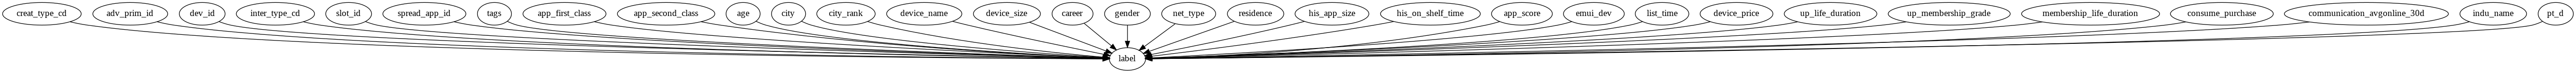

In [ ]:
model=CausalModel(
        data = newdf,
        treatment='dev_id',
        outcome='label',
        graph=dot_graph
        )
model.view_model()


display(Image(filename="causal_model.png"))

In [ ]:
colname

Index(['Unnamed: 0', 'label', 'uid', 'task_id', 'adv_id', 'creat_type_cd',
       'adv_prim_id', 'dev_id', 'inter_type_cd', 'slot_id', 'spread_app_id',
       'tags', 'app_first_class', 'app_second_class', 'age', 'city',
       'city_rank', 'device_name', 'device_size', 'career', 'gender',
       'net_type', 'residence', 'his_app_size', 'his_on_shelf_time',
       'app_score', 'emui_dev', 'list_time', 'device_price',
       'up_life_duration', 'up_membership_grade', 'membership_life_duration',
       'consume_purchase', 'communication_avgonline_30d', 'indu_name', 'pt_d'],
      dtype='object')

In [ ]:
treatment_text=['creat_type_cd', 'adv_prim_id','dev_id', 'inter_type_cd', 'slot_id', 'spread_app_id', 'tags',
       'app_first_class', 'app_second_class', 'age', 'city', 'city_rank',
       'device_name', 'device_size', 'career', 'gender', 'net_type',
       'residence', 'his_app_size', 'his_on_shelf_time', 'app_score',
       'emui_dev', 'list_time', 'device_price', 'up_life_duration',
       'up_membership_grade', 'membership_life_duration', 'consume_purchase',
      'communication_avgonline_30d', 'indu_name',
       'pt_d']
new_eff=np.zeros(np.size(treatment_text))
estimated_eff=np.zeros(np.size(treatment_text))

NameError: ignored

In [ ]:
treatment_text[17]

'residence'

In [ ]:
newdf

,Unnamed: 0,label,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,...,emui_dev,list_time,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_avgonline_30d,indu_name,pt_d
4304,4304,1,1415478,1086,6422,3,142,36,5,17,...,27,12,4,16,-1,-1,2,11,42,3
11037,11037,0,1581804,3434,3412,7,156,60,5,13,...,12,9,3,20,1,-1,2,13,24,2
11412,11412,0,1050663,2361,5555,3,142,36,5,17,...,20,8,4,18,-1,-1,2,13,42,3
5480,5480,1,1869584,4335,5710,6,150,17,5,18,...,14,14,2,9,-1,-1,2,7,36,4
9397,9397,0,1924985,5946,1657,7,110,38,5,17,...,12,9,3,20,-1,-1,2,12,30,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3143,3143,1,1833387,2389,5768,7,177,56,5,12,...,20,16,1,14,-1,-1,2,13,17,5
7368,7368,0,2094224,2211,4079,8,142,60,5,17,...,20,4,4,-1,-1,-1,2,12,42,1
12365,12365,0,1602443,2183,4262,7,207,17,5,16,...,14,8,4,-1,-1,-1,2,11,17,4
12809,12809,0,1647397,2269,2674,7,144,43,5,16,...,12,9,4,20,-1,-1,2,10,18,4


In [ ]:

for i in range(np.size(treatment_text)):

  model=CausalModel(
        data = newdf,
        treatment=treatment_text[i],
        outcome='label',
        graph=dot_graph
        )

  #model.view_model()
  
  identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
  causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)
  refutation = model.refute_estimate(identified_estimand, causal_estimate, method_name="placebo_treatment_refuter",
                                  placebo_type="permute", num_simulations=20)
  new_eff[i]=refutation.new_effect
  estimated_eff[i]=refutation.estimated_effect

                 Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.
                 Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.
                 Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.
                 Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.
                 Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.
                 Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.
                 Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.
                 Not

In [ ]:
new_eff

array([ 1.85051262e-03,  1.97317258e-04, -6.50943336e-05,  8.44171745e-03,
        1.07534155e-03, -1.61600666e-04,  9.38159901e-04,  2.21842221e-05,
        5.24682463e-04,  1.38286094e-04,  4.51139090e-05,  2.96671105e-03,
       -2.13845536e-05,  6.37596294e-05,  5.20486095e-04, -4.00457901e-03,
       -6.43960776e-03, -7.55514088e-05,  3.66855616e-04, -3.82475201e-03,
        3.23887497e-02,  9.16059036e-04, -1.35593824e-03,  7.65485729e-03,
       -1.15509021e-05,  7.62754669e-03, -2.53000000e-01, -1.72404139e-04,
        2.68059594e-03, -1.41627516e-04,  5.93746195e-04])

In [ ]:
estimated_eff

array([-1.25407031e-01,  9.54758370e-04,  1.69014337e-03, -1.50366670e-01,
       -2.04495392e-02, -1.03014163e-03,  1.96834370e-02, -2.17918760e-01,
       -1.65467245e-02,  1.11968646e-02, -8.30554114e-05,  6.73745830e-03,
        3.02232926e-04,  5.01179532e-04,  6.34401536e-03, -4.46255823e-03,
        1.25276807e-01, -4.32226020e-03, -1.89124171e-02, -6.85651026e-02,
       -5.54579983e-01,  4.81502781e-03,  5.01780352e-03, -5.18583374e-02,
       -8.25663621e-03, -2.15562856e-01, -2.53000000e-01, -7.76170961e-02,
       -1.68958518e-02,  5.34393756e-04, -6.95323359e-03])

In [ ]:
esti=np.array([[ -1.25407031e-01,  9.54758370e-04,  1.69014337e-03, -1.50366670e-01,
       -2.04495392e-02, -1.03014163e-03,  1.96834370e-02, -2.17918760e-01,
       -1.65467245e-02,  1.11968646e-02, -8.30554114e-05,  6.73745830e-03,
        3.02232926e-04,  5.01179532e-04,  6.34401536e-03, -4.46255823e-03,
        1.25276807e-01, -4.32226020e-03, -1.89124171e-02, -6.85651026e-02,
       -5.54579983e-01,  4.81502781e-03,  5.01780352e-03, -5.18583374e-02,
       -8.25663621e-03, -2.15562856e-01, -2.53000000e-01, -7.76170961e-02,
       -1.68958518e-02,  5.34393756e-04, -6.95323359e-03]])
temp1=np.array([[-3.95882099e-03, -4.66659267e-06, -4.21405471e-04,  1.23255969e-02,
        1.85940860e-03, -2.61284366e-05, -2.67626125e-04, -5.82750753e-03,
       -5.96268729e-04, -3.17372067e-03, -4.50965237e-05, -3.56438003e-03,
       -3.85690149e-04, -4.15316534e-05,  4.25053266e-04,  6.52150841e-03,
        2.99792017e-03, -1.21687536e-04, -1.73264209e-03, -1.22474376e-03,
        1.88035109e-02,  1.80307122e-04, -1.11190353e-03, -3.17669065e-03,
       -1.57626893e-04, -2.46548740e-02, -2.32491774e-03, -1.00404172e-02,
       -1.73578584e-03, -2.17642774e-04, -5.15371262e-03]])
temp2=np.array([[-5.13568769e-03,  1.11251909e-04,  2.52886160e-04, -4.70316312e-03,
        2.03130621e-04, -2.66889834e-04, -1.20073312e-03,  1.91978516e-02,
        1.84530408e-03, -2.51696959e-03,  5.31683021e-05,  3.92749725e-03,
        2.15096642e-04, -3.17559458e-05,  7.84156517e-04,  2.08362394e-03,
       -1.64371682e-02, -9.36470244e-05,  1.25647337e-04,  3.01368521e-03,
       -2.11040653e-02,  5.50563565e-04, -3.47901718e-04, -8.50737089e-04,
       -2.67273135e-04,  9.26754290e-03, -2.53000000e-01,  2.86352869e-03,
       -9.63604513e-03,  2.69180907e-04,  6.33667118e-04]])
temp3=np.array([[4.62308046e-03,  2.94010200e-05,  8.27119272e-05,  1.82118572e-02,
        2.31259104e-03,  1.11585468e-04, -5.31740896e-05,  1.05423219e-02,
        5.15761987e-04, -3.23184651e-03,  4.07299827e-05,  4.23483372e-03,
        2.75051560e-04,  1.90333716e-05,  1.28504986e-03,  4.82726772e-03,
        9.63402019e-03,  8.02643567e-04,  2.18766108e-04, -8.11014785e-04,
       -4.14341305e-03,  3.63748870e-04, -7.89844258e-04,  4.14262307e-03,
        5.85744820e-04, -3.49885824e-03, -2.53000000e-01, -2.46165747e-03,
       -7.24279299e-03,  4.91517328e-04,  3.80035294e-04]])
temp4=np.array([[8.19948092e-03,  2.70296366e-04, -2.13071565e-05, -1.55584211e-03,
       -1.27000677e-03,  4.42311104e-04, -2.05038643e-04, -5.64398967e-04,
        1.20835598e-03,  4.18174100e-04, -4.02581223e-05, -2.42182156e-03,
        3.04330004e-05, -1.22702925e-05,  3.73623371e-03, -5.83271197e-03,
        8.58669503e-03,  4.84535070e-07, -2.80559565e-04, -2.13003642e-03,
       -1.22997025e-02, -2.00658067e-03,  2.24004621e-03,  2.62692705e-03,
        3.86386951e-04,  2.53236587e-03, -2.53000000e-01,  8.21257885e-03,
        5.99009241e-03, -7.00401553e-04, -1.71791942e-03]])
temp5=np.array([[3.26616492e-03, -2.12709788e-04,  2.44074735e-04,  1.20924757e-02,
       -5.41271121e-04,  1.02551074e-04,  7.37526347e-05, -3.33526967e-03,
       -1.14035419e-03,  4.48025375e-03, -5.30477860e-05, -6.14362326e-03,
        1.13962022e-04,  2.33367000e-05,  2.21835087e-04, -9.75754233e-03,
        2.46359337e-02,  6.41704804e-04,  6.48624966e-04, -1.82809077e-03,
        1.33500818e-02, -3.95171826e-04, -2.20761870e-03,  2.44348856e-03,
        4.15567792e-04, -1.53862516e-02, -2.53000000e-01, -4.50314612e-03,
        5.44230191e-03,  3.21318950e-04,  1.08796049e-03]])
temp6=np.array([[6.75787031e-04,  2.79444340e-04, -5.11250564e-04,  1.24023637e-02,
       -2.72751294e-04, -3.77635581e-05, -3.60550899e-04,  5.45898167e-03,
        4.05431483e-04, -1.68357431e-05,  7.04512058e-05, -5.54614105e-03,
        1.49132246e-05,  2.50355941e-04, -1.96362301e-03,  4.86567559e-03,
        2.90147602e-03,  1.20981049e-04, -6.01744123e-05,  1.44118527e-03,
        3.95823925e-03,  1.98729358e-03,  1.58894254e-04, -5.61247184e-04,
       -6.18752563e-05, -6.02034472e-03, -2.53000000e-01,  1.17471636e-02,
       -9.31948713e-04,  8.26637405e-06,  1.18523904e-03]])
temp7=np.array([[-6.12200622e-04,  3.94015750e-05,  2.85378035e-04, -1.16604419e-02,
       -2.49400080e-03,  1.43006970e-04,  1.20418076e-04,  3.25778134e-03,
        1.62112770e-03,  4.54979098e-03,  1.32118425e-05, -5.77109316e-03,
        5.43310001e-04, -1.18109305e-04,  3.05631402e-03,  8.45062895e-03,
       -1.05381705e-03, -1.47415988e-04,  5.60856351e-04,  2.95134889e-03,
       -1.90492870e-03,  1.82741936e-04, -5.65070807e-04, -2.05551676e-03,
       -6.87224986e-05,  2.69841642e-03, -2.53000000e-01, -3.47152701e-03,
       -5.22679783e-04,  4.44272962e-04,  1.54248357e-03]])
temp8=np.array([[-1.25040082e-04,  9.36662804e-05, -4.58259282e-04,  2.25293555e-03,
       -9.64809249e-05, -2.11656169e-04,  3.87082629e-04,  4.52881161e-03,
       -1.80417962e-03, -2.94571075e-03, -6.37174266e-05,  3.18895726e-03,
       -6.77016836e-05,  1.49955874e-04,  1.17012098e-03, -7.57361800e-04,
        1.33600684e-02,  3.17748384e-04, -8.58580529e-04, -1.24032496e-03,
       -2.36054122e-02, -4.28701968e-05, -1.51729342e-03, -7.82203906e-03,
       -3.34817987e-04,  1.42872327e-02, -2.53000000e-01, -5.86147897e-03,
        8.98738673e-04, -4.95154930e-04, -2.16849324e-03]])
temp9=np.array([[6.13165417e-04, -1.38604929e-04,  1.02711733e-04,  1.32257774e-03,
       -3.94980953e-03,  3.49285742e-05,  3.47058271e-04,  2.23763543e-03,
       -3.88260304e-04, -2.63662608e-03, -3.09547914e-05, -1.12136564e-02,
       -3.80801650e-05, -8.50954133e-06, -1.31002587e-03, -3.28475938e-03,
       -5.04435206e-03,  3.31508483e-04, -7.21290441e-04, -7.39462008e-04,
        1.06386879e-02, -1.42814628e-03,  3.15383261e-04, -2.24442828e-04,
       -7.08322844e-04, -6.61264348e-03, -2.53000000e-01,  3.29544213e-03,
        4.43189035e-03, -3.73547044e-04,  2.61250316e-03]])
temp10=np.array([[6.06257449e-03,  1.59090475e-04, -5.03650486e-05, -7.01832176e-03,
       -1.48479355e-03, -2.12214256e-04,  7.88694610e-04,  1.42326569e-03,
       -9.18343437e-04,  7.52790320e-04,  4.05356588e-05, -9.47388873e-03,
       -5.21553365e-04, -3.81215406e-06, -2.41023233e-03,  6.22760253e-04,
        2.86706023e-03,  4.52418144e-04, -5.30228137e-05, -3.42583260e-03,
        8.17861839e-03, -9.46112455e-04, -1.22222953e-03,  2.43424202e-03,
        4.54962281e-04,  4.69362514e-03, -2.53000000e-01,  8.43248571e-03,
       -2.30743937e-03, -2.19323713e-05, -2.58388240e-04]])
temp11=np.array([[5.20727043e-03, -1.11600175e-04,  2.05236302e-04,  2.06151027e-02,
       -1.44655639e-03,  1.70824213e-04,  4.76533680e-04, -6.13391734e-03,
        1.38261758e-04, -6.97785527e-03,  3.49757591e-05, -1.15535033e-02,
        8.07346509e-05, -3.10124810e-04, -1.98368078e-03,  1.36716731e-04,
        1.37699202e-02, -6.82440372e-04, -4.20939626e-04, -2.61503504e-03,
       -1.33185599e-02,  2.43835983e-05, -3.05688440e-04,  3.29075447e-04,
        1.35935974e-03, -1.22569353e-02, -2.53000000e-01, -2.58235202e-03,
        1.00662604e-03,  1.68857134e-04, -4.15880386e-03]])
temp12=np.array([[8.87154494e-03,  1.03414865e-04, -2.53350184e-04, -5.07550192e-03,
        3.14038105e-03, -8.27406803e-05,  9.28146341e-04,  6.04155126e-03,
        1.51758364e-04, -2.83876671e-03, -6.86879914e-05,  6.87052689e-03,
        1.25236603e-04, -2.50829645e-04, -5.71960965e-03,  1.16923147e-02,
       -2.75899173e-02,  3.11839752e-04,  1.51569618e-04,  4.43406816e-04,
        1.75068680e-03,  1.38156464e-03,  3.18978978e-04, -4.69308328e-03,
        8.61978208e-04, -1.36511678e-03, -2.53000000e-01,  1.60103456e-03,
        4.65390439e-03,  1.17428669e-04, -2.94553263e-03]])
temp13=np.array([[2.69191423e-03, -1.70184863e-04,  4.75432475e-06,  2.45969070e-03,
       -2.75127889e-03, -1.51902045e-04,  9.05777088e-04, -8.03013087e-03,
       -7.13074867e-05,  6.83322762e-04, -4.49623980e-05, -9.90802703e-03,
        3.65774932e-04, -1.18846612e-04,  5.26875390e-04, -2.47248693e-05,
       -1.11476032e-02, -9.20778256e-04,  1.75043130e-03, -8.55975267e-03,
        1.78223601e-02, -3.00331787e-04,  1.25915644e-03,  1.90680428e-03,
        6.10981017e-04,  3.21990320e-03, -2.53000000e-01, -5.27863083e-03,
        9.57789744e-04,  6.02922062e-05,  4.64208388e-03]])
temp14=np.array([[-3.09415577e-03, -6.85573075e-05,  3.15001225e-04,  1.58435708e-02,
       -1.59211971e-05, -8.91814811e-05, -1.38201267e-03, -1.02863038e-02,
       -1.75934914e-03,  3.56376029e-04,  3.80139960e-05,  5.04549284e-03,
        5.89149472e-04, -3.20284081e-05,  1.89112465e-03,  1.65054831e-03,
        4.25240613e-03,  1.86251970e-04, -9.09819710e-04,  6.23864209e-03,
       -1.91896929e-02, -1.54508943e-05,  2.55044414e-04,  2.95604892e-03,
        6.70444540e-05, -4.98741896e-03, -2.53000000e-01, -9.56415119e-03,
       -2.79941221e-03, -1.71941776e-04,  5.51841426e-04]])
temp15=np.array([[1.24589529e-03,  2.51956958e-04, -6.10726572e-05,  9.61558010e-03,
       -4.89223326e-04, -2.69813180e-04,  1.65122894e-04,  9.78553020e-03,
        1.19529890e-03,  1.53348352e-04, -4.15773931e-05,  5.79146162e-03,
       -1.19720023e-04, -6.47891649e-05,  5.59929193e-04,  4.59241048e-03,
        2.96659379e-03, -2.71103579e-04,  3.16379826e-04,  4.31599019e-03,
       -2.97683726e-03,  5.97747852e-04,  1.75118867e-03,  2.88346389e-03,
       -2.55027565e-04,  1.99917566e-03, -2.53000000e-01,  1.55194066e-03,
        1.80318044e-03,  1.11156109e-04,  1.75785482e-03]])
temp16=np.array([[-5.36049786e-03,  1.79828396e-04, -7.79612825e-05,  6.93945342e-03,
       -2.57405791e-03,  2.79582090e-04, -1.34489626e-04,  6.52161406e-04,
       -8.37534848e-04,  2.75099601e-03, -3.81977431e-05, -1.24071926e-02,
       -1.07142140e-04, -1.94189348e-04, -1.75077194e-03, -2.44561632e-04,
       -1.18481134e-02,  1.86831069e-04, -1.59686002e-03,  3.10651243e-04,
        2.46187568e-02, -1.02086083e-03,  5.64031669e-04,  4.03951871e-03,
       -5.78318019e-04, -5.14974620e-03, -2.53000000e-01,  3.48695297e-03,
       -1.52267857e-03,  1.69443537e-04, -2.77500082e-03]])
temp17=np.array([[2.22861391e-03, -1.41233798e-04, -3.36037712e-04, -1.72022223e-03,
        6.23095436e-04, -2.01134533e-04, -6.49274662e-04,  5.52650456e-04,
       -8.46987439e-04,  1.34690633e-03, -2.28913177e-05,  1.69473235e-03,
       -2.88861263e-04,  2.03495385e-04,  7.58770520e-04, -5.54913184e-03,
       -2.70152897e-02,  5.14893493e-04, -5.22421505e-04, -1.41262552e-03,
        2.65789556e-03,  1.91503073e-03, -1.33172708e-03, -4.78376213e-03,
        6.93744590e-04, -2.05644308e-02, -2.53000000e-01,  1.37005660e-02,
       -4.05947372e-03, -2.05547325e-04, -7.02582759e-03]])
temp18=np.array([[8.92631976e-03, -8.51930437e-05, -1.00348714e-04, -9.10722886e-03,
        3.72803506e-03, -1.47715077e-04, -1.22298199e-04, -1.09872452e-02,
        4.50454557e-04, -2.73695830e-03, -6.38716093e-05, -2.13926968e-03,
        3.78806031e-05,  1.13108329e-04, -4.16795838e-03,  5.12834088e-04,
       -2.01341034e-02,  9.77929874e-04, -2.50822867e-04,  1.60091774e-04,
        2.30565010e-03, -1.28847558e-03,  6.88306405e-04,  1.28870413e-03,
        1.36582988e-03,  1.58172828e-02, -2.53000000e-01,  3.90524428e-03,
       -4.03485194e-03, -2.73483692e-04, -1.51470098e-03]])
temp19=np.array([[-3.17133927e-03, -1.74541419e-04,  4.77493020e-04, -1.40714047e-02,
        1.79249147e-03, -8.36497210e-05, -1.74272285e-03, -2.44309136e-03,
        1.00781202e-03,  1.19314947e-03,  8.15771698e-05, -8.11243492e-03,
       -3.52860472e-04,  1.01584016e-04, -3.37448830e-04, -3.50392959e-03,
        6.32031829e-03,  4.07811346e-04,  2.67596177e-04, -2.90825040e-03,
       -9.84932380e-03, -6.54722283e-04, -1.53873998e-03,  2.85144910e-04,
        4.47015646e-04,  7.92134085e-04, -2.53000000e-01,  6.97155211e-03,
       -6.92720280e-04,  5.17629768e-04, -1.40729152e-03]])
temp20=np.array([[1.85051262e-03,  1.97317258e-04, -6.50943336e-05,  8.44171745e-03,
        1.07534155e-03, -1.61600666e-04,  9.38159901e-04,  2.21842221e-05,
        5.24682463e-04,  1.38286094e-04,  4.51139090e-05,  2.96671105e-03,
       -2.13845536e-05,  6.37596294e-05,  5.20486095e-04, -4.00457901e-03,
       -6.43960776e-03, -7.55514088e-05,  3.66855616e-04, -3.82475201e-03,
        3.23887497e-02,  9.16059036e-04, -1.35593824e-03,  7.65485729e-03,
       -1.15509021e-05,  7.62754669e-03, -2.53000000e-01, -1.72404139e-04,
        2.68059594e-03, -1.41627516e-04,  5.93746195e-04]])

In [ ]:
 new_data=np.concatenate((temp1,temp2,temp3,temp4,temp5,temp6,temp7,temp8,temp9,temp10,temp11,temp12,temp13,temp14,temp15,temp16,temp17,temp18,temp19,temp20),axis=0)

In [ ]:
new_data=pd.DataFrame(new_data,columns =range(1,32))

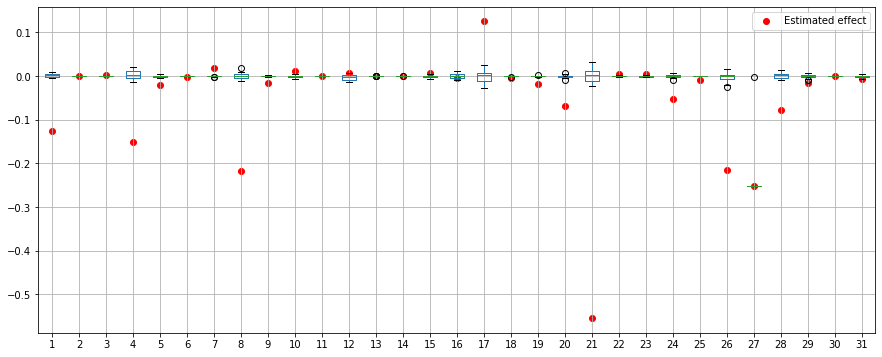

In [ ]:
plt.figure(figsize=(15,6))
new_data.boxplot()
plt.scatter(range(1,32),esti,marker='o',c='r',label='Estimated effect')
plt.legend()